In [1]:
__author__ = 'Kayli Glidic'

# Import Library

In [4]:
#import the spectroscopic module from the tshirt pipeline
from tshirt.pipeline import spec_pipeline

#import the RECTE charge correction functions
import Charge_Correction_Functions
from Charge_Correction_Functions import RECTE,RECTEMulti,calculate_correction_fast, charge_correction

#import basic plotting libraries/set plot settings
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
%matplotlib inline

#import bokeh to enable interactive plots
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
output_notebook()

#import yaml to read in the parameter file
import yaml

#Basic imports
import os
from astropy.table import QTable
import astropy.units as u
import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table, join
import pandas as pd
from astropy.time import Time
from copy import deepcopy
import time
from multiprocessing import Pool

#modeling transit/eclipse light curves
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import batman
import corner
import emcee


#to fix errors
import pdb

#to correct for time differences
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation


Could not import ccdproc, so image processing may not work


Loading BokehJS ...

ModuleNotFoundError: No module named 'pandas'

# Batch Processing the Spectroscopic Data on CoRoT-1 b

In [2]:
#read in yaml batch parameter file on CoRoT-1 b 
with open("corot1_batch_file_apWidth.yaml", "r") as stream:
    bparamfile = yaml.safe_load(stream)

bparamfile

{'procFiles': ['/fenrirdata1/es_tso/hst/visit01/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit02/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit03/*_flt.fits',
  '/fenrirdata1/es_tso/hst/visit04/*_flt.fits'],
 'excludeList': ['ibh717giq_flt.fits',
  'ibh719gkq_flt.fits',
  'ibh720i5q_flt.fits',
  'ibh721olq_flt.fits'],
 'srcName': 'CoRoT-1',
 'srcNameShort': 'corot1-aptWidth',
 'nightName': ['visit1', 'visit2', 'visit3', 'visit4'],
 'dispDirection': 'x',
 'starPositions': [74],
 'refPhotCentering': None,
 'bkgSubDirections': ['Y'],
 'bkgRegionsX': [[None, None]],
 'bkgOrderX': 0,
 'bkgRegionsY': [[[9, 32], [41, 49], [92, 122]],
  [[0, 14], [25, 32], [39, 56], [100, 121]],
  [[9, 32], [39, 46], [92, 122]],
  [[9, 32], [39, 46], [92, 122]]],
 'bkgOrderY': 1,
 'apWidth': 100.0,
 'dispPixels': [0, 128],
 'numSplineKnots': 6,
 'splineSpecFitOrder': 2,
 'sigForBadPx': 300,
 'jdRef': 2457551,
 'timingMethod': None,
 'isCube': False,
 'cubePlane': 0,
 'doCentering': False,
 'FITSextension': 1,
 '

In [3]:
bspec = spec_pipeline.batch_spec(batchFile='corot1_batch_file_apWidth.yaml') #create a batch_spec object

Working on showStarChoices for batch CoRoT-1 corot1-aptWidth_visit1 
Working on showStarChoices for batch CoRoT-1 corot1-aptWidth_visit2 
Working on showStarChoices for batch CoRoT-1 corot1-aptWidth_visit3 
Working on showStarChoices for batch CoRoT-1 corot1-aptWidth_visit4 


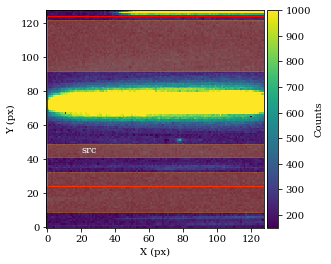

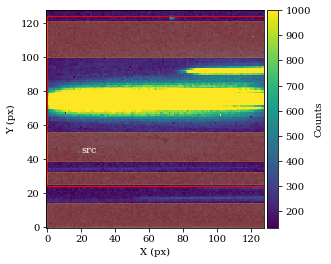

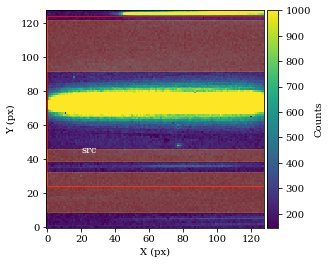

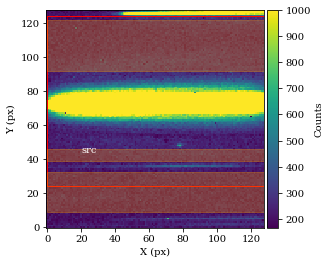

In [4]:
bspec.batch_run('showStarChoices',vmax=1000,showPlot=True) #show the star choices for spectroscopy for each visit

In [5]:
bspec.batch_run('do_extraction',useMultiprocessing=True) #extract all spectroscopy

Working on do_extraction for batch CoRoT-1 corot1-aptWidth_visit1 


100%|██████████| 98/98 [00:03<00:00, 27.87it/s]


Working on do_extraction for batch CoRoT-1 corot1-aptWidth_visit2 


100%|██████████| 98/98 [00:03<00:00, 27.91it/s]


Working on do_extraction for batch CoRoT-1 corot1-aptWidth_visit3 


 70%|███████   | 69/98 [00:02<00:01, 19.43it/s]/home/kglidic/miniconda3/envs/astroconda/lib/python3.6/site-packages/tshirt/pipeline/utils.py:113: UserWarning: Spline fitting failed because of Schoenberg-Whitney conditions. Trying to eliminate knots without sufficient data
  warnings.warn("Spline fitting failed because of Schoenberg-Whitney conditions. Trying to eliminate knots without sufficient data")
100%|██████████| 98/98 [00:03<00:00, 28.05it/s]


Working on do_extraction for batch CoRoT-1 corot1-aptWidth_visit4 


100%|██████████| 98/98 [00:03<00:00, 28.14it/s]


Working on plot_one_spec for batch CoRoT-1 corot1-aptWidth_visit1 


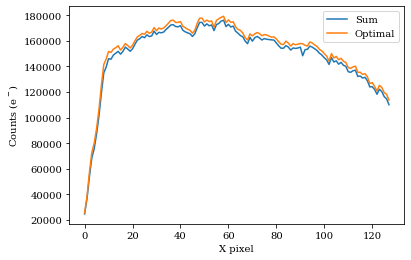

Working on plot_one_spec for batch CoRoT-1 corot1-aptWidth_visit2 


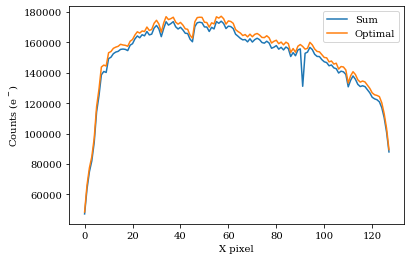

Working on plot_one_spec for batch CoRoT-1 corot1-aptWidth_visit3 


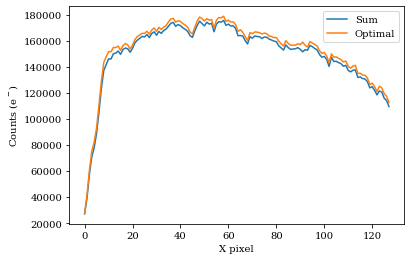

Working on plot_one_spec for batch CoRoT-1 corot1-aptWidth_visit4 


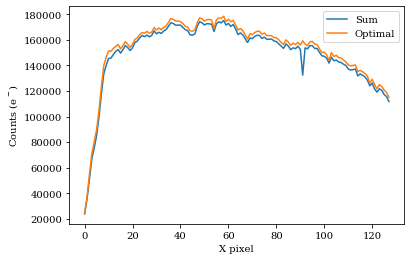

In [6]:
bspec.batch_run('plot_one_spec') #plot the spectrum of the source for each visit

Working on plot_dynamic_spec for batch CoRoT-1 corot1-aptWidth_visit1 
Working on plot_dynamic_spec for batch CoRoT-1 corot1-aptWidth_visit2 
Working on plot_dynamic_spec for batch CoRoT-1 corot1-aptWidth_visit3 
Working on plot_dynamic_spec for batch CoRoT-1 corot1-aptWidth_visit4 


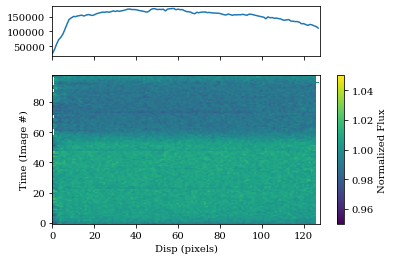

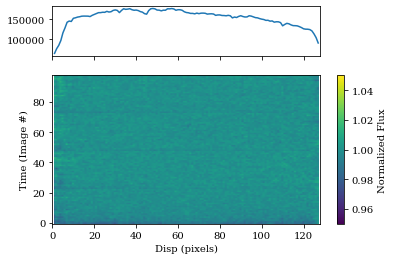

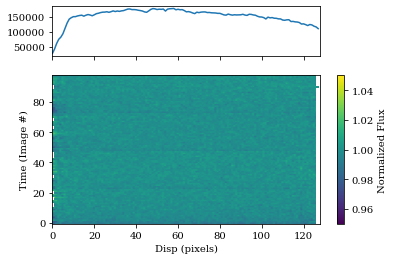

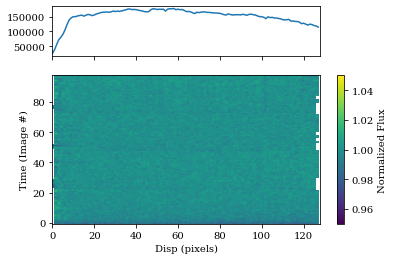

In [7]:
bspec.batch_run('plot_dynamic_spec', showPlot=True,align=True) #plot the dynamic spectrum for each visit

In [8]:
#Bin the wavelengths together and generate a time series from the aligned dynamic spectrum (`make_wavebin_series`)
#Plot a normalized lightcurve for wavelength-binned data one wavelength at a time with an offset between the lightcurves (`plot_wavebin_series`)

bspec.batch_run('make_wavebin_series',align=True,dispIndices=[10,118],recalculate=True,nbins=1) #Set dispersion indices based on alignment step above in `plot_dynamic_spec`and recalculate the dynamic spectrum..
bspec.batch_run('plot_wavebin_series', nbins=1, interactive=False,showPlot=False)

Working on make_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit1 
Remaking dynamic spectrum...
Working on make_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit2 
Remaking dynamic spectrum...
Working on make_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit3 
Remaking dynamic spectrum...
Working on make_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit4 
Remaking dynamic spectrum...
Working on plot_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit1 
Working on plot_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit2 
Working on plot_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit3 
Working on plot_wavebin_series for batch CoRoT-1 corot1-aptWidth_visit4 


In [9]:
#Return a spectrometry object for each visit so other methods and attributes can be explored
spec_v1 = bspec.return_spec_obj(ind=0)
spec_v2 = bspec.return_spec_obj(ind=1)
spec_v3 = bspec.return_spec_obj(ind=2)
spec_v4 = bspec.return_spec_obj(ind=3)

### Reading in Vist Data 

In [10]:
#read in result files
corot1_visit1_results = pd.read_csv('CSV_Visit_Files/corot1_visit1_results.csv')
corot1_visit2_results = pd.read_csv('CSV_Visit_Files/corot1_visit2_results.csv')
corot1_visit3_results = pd.read_csv('CSV_Visit_Files/corot1_visit3_results.csv')
corot1_visit4_results = pd.read_csv('CSV_Visit_Files/corot1_visit4_results.csv')

#read in median fit files
median_image_v1 = fits.getdata('Median_Images/corot1_visit1_median_image.fits')
median_image_v2 = fits.getdata('Median_Images/corot1_visit2_median_image.fits')
median_image_v3 = fits.getdata('Median_Images/corot1_visit3_median_image.fits')
median_image_v4 = fits.getdata('Median_Images/corot1_visit4_median_image.fits')

# Modeling Transit/Eclipses

In [11]:
def transit_model(x, rp, a, b):
    '''
    Models transit light curve based on initial parameters stored in params_transit.
    
    Parameters
    ----------
    
    x: array
        Time in Julian days 
    rp: int
        Radius of the planet
    a: int
        Flux Normalization value
    b: int
        Slope Flux Normalization value
    '''
    #Get the values specific to CoRoT-1b for planet radius and semi-major axis in units of stellar radii.
    Rstar = 1.230 * u.Rsun #CoRoT-1 star radius (in units of Solar radii) #Bonomo et al. 2017
    a_axis = 0.02752 * u.au #semi-major axis (in units of AU) #Bonomo et al. 2017
    a_over_r = (a_axis/Rstar).si.value #Calculated - semi-major axis (in units of stellar radii)

    params_transit = batman.TransitParams()                   #Object to store transit parameters
    
    params_transit.t0 = 2454138.32807 #Bonomo et al. 2017     #time of inferior conjunction (days)
    params_transit.per = 1.5089682    #Bonomo et al. 2017     #orbital period (days)
    params_transit.a = a_over_r       #Bonomo et al. 2017     #semi-major axis (in units of stellar radii)
    params_transit.inc =85.15         #Bonomo et al. 2017     #orbital inclination (in degrees)
    params_transit.ecc = 0.           #Bonomo et al. 2017     #eccentricity
    params_transit.w = 90.                                    #longitude of periastron (in degrees)
    params_transit.limb_dark = "nonlinear"                    #limb darkening model
    params_transit.u = [0.5, 0.1, 0.1, -0.1]                  #limb darkening coefficients [u1, u2, u3, u4]


    params_transit.rp = rp #planet radius will depend on input
    m = batman.TransitModel(params_transit, x)
    
    #Modifying the slope: Julian Date(x) - Initial Julian Date(x0) 
    x0 = np.min(x)
    flux = m.light_curve(params_transit)*(a+b*(x-x0))
    return flux

In [12]:
#one must define the global parameters im, exptime, and xList for each visit
def transit_model_RECTE(x, rp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f):
    '''
    Models transit light curve based on initial parameters stored in params_transit and RECTE charge trapping parameters. 
    
    Parameters
    ----------
    
    x: array
        Time in Julian days 
    rp: int
        Radius of the planet
    a: int
        Flux Normalization value
    b: int
        Slope Flux Normalization value
        
    trap_pop_s: int
        (default=0)number of initially occupied traps -- slow poplulation
        
    trap_pop_f: int
        (default=0)number of initially occupied traps -- fast poplulation
    
    dtrap_s: int
        (default=0, can be either number or list) number of extra
        trapped charge carriers added in the middle of two orbits
        -- slow population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
    
    dtrap_f: int
        (default=0, can be either number or list) number of extra
         trapped charge carriers added in the middle of two orbits
        -- fast population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
        
    '''
    global im
    global exptime
    global xList
    
    #Define the initial flux for the model based on the regular transit_model function
    flux = transit_model(x,rp,a,b)
    
    #Define the ramp in the initial flux
    ramp=calculate_correction_fast(x,exptime,im,xList=xList,trap_pop_s=trap_pop_s, dTrap_s=[dtrap_s], trap_pop_f=trap_pop_f, dTrap_f=[dtrap_f])
    
    #return the modified flux based on the ramp in the data
    flux_modified = flux*np.mean(ramp,axis=0)
    return flux_modified


In [13]:
def eclipse_model(x, fp, a, b):
    '''
    Models eclipse light curve based on initial parameters stored in params_eclipse.
    
    Parameters
    ----------
    
    x: array
        Time in days 
        
    fp: int
        planet-to-star flux ratio
        
    a: int
        Flux Normalization value
        
    b: int
        Slope Flux Normalization value
        
    '''
    #Get the values specific to CoRoT-1b for planet radius and semi-major axis in units of stellar radii.
    rp =1.715 * u.Rjupiter #planet radius rp (in units of Jupiter radii)  #Bonomo et al. 2017
    Rstar = 1.230 * u.Rsun #CoRoT-1 star radius (in units of Solar radii) #Bonomo et al. 2017
    planet_radius = (rp/Rstar).si.value #Calculated - planet radius (in units of stellar radii)
    a_axis = 0.02752 * u.au #semi-major axis (in units of AU) #Bonomo et al. 2017
    a_over_r = (a_axis/Rstar).si.value #Calculated - semi-major axis (in units of stellar radii)
    
    params_eclipse = batman.TransitParams()       #object to store secondary eclipse parameters
    
    params_eclipse.t0 = 2454138.32807   #Bonomo et al. 2017         #time of inferior conjunction (days)
    params_eclipse.per = 1.5089682      #Bonomo et al. 2017         #orbital period (days)
    params_eclipse.rp =  planet_radius  #Bonomo et al. 2017         #planet radius (in units of stellar radii)
    params_eclipse.a = a_over_r         #Bonomo et al. 2017         #semi-major axis (in units of stellar radii)
    params_eclipse.inc =85.10           #Bonomo et al. 2017         #orbital inclination (in degrees)
    params_eclipse.ecc = 0.             #Bonomo et al. 2017         #eccentricity
    params_eclipse.w = 90.                                          #longitude of periastron (in degrees)
    params_eclipse.limb_dark = "nonlinear"                          #limb darkening model
    params_eclipse.u = [0.5, 0.1, 0.1, -0.1]                        #limb darkening coefficients [u1, u2, u3, u4]
    params_eclipse.t_secondary = params_eclipse.t0 + 0.5* 1.5089682 #The central eclipse time
    
    params_eclipse.fp = fp/1000000 #planet-to-star flux ratio (fp) is in ppm
    m = batman.TransitModel(params_eclipse, x, transittype="secondary")
    
    #Modifying the slope: Julian Date(x) - Initial Julian Date(x0) 
    x0 = np.min(x)
    flux = m.light_curve(params_eclipse)*(a+b*(x-x0)) 
    return flux

In [14]:
#one must define the global parameters im, exptime, and xList for each visit
def eclipse_model_RECTE(x, fp, a, b, trap_pop_s, dtrap_s, trap_pop_f, dtrap_f):
    '''
    Models eclipse light curve based on initial parameters stored in params_eclipse and RECTE charge trapping parameters.
    
    Parameters
    ----------
    
    x: array
        Time in days 
    fp: int
        Planet-to-flux ratio
    a: int
        Flux Normalization value
        
    b: int
        Slope Flux Normalization value
        
    trap_pop_s: int
        (default=0)number of initially occupied traps -- slow poplulation
    
    trap_pop_f: int
        (default=0)number of initially occupied traps -- fast poplulation
    
    dTrap_s: int
        (default=0, can be either number or list) number of extra
        trapped charge carriers added in the middle of two orbits
        -- slow population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
        
     dtrap_f: int
        (default=0, can be either number or list) number of extra
         trapped charge carriers added in the middle of two orbits
        -- fast population. If it is a number, it assumes that all
        the extra added trap charge carriers are the same
        
    '''
    global im
    global exptime
    global xList
    
    #Define the initial flux for the model based on the regular eclipse_model function
    flux = eclipse_model(x,fp,a,b)
    
    #Define the ramp in the initial flux
    ramp=calculate_correction_fast(x,exptime,im,xList=xList,trap_pop_s=trap_pop_s, dTrap_s=[dtrap_s], trap_pop_f=trap_pop_f, dTrap_f=[dtrap_f])
    
    #return the modified flux based on the ramp in the data
    flux_modified = flux*np.mean(ramp,axis=0)
    return flux_modified


In [15]:
def barycenter_correction(self):
    t1, t2 = self.get_wavebin_series()
    head = fits.getheader(self.fileL[0])
    #print("Time from tshirt: {}".format(t1['Time'][0]))
    
    expStartJD = head['EXPSTART'] + 2400000.5
    #print("Time from EXPSTART keyword {}".format(expStartJD))
    
    t1 = Time(t1['Time'][0],format='jd')
    coord = SkyCoord('06 48 19.1724141241 -03 06 07.710423478',unit=(u.hourangle,u.deg))
    loc = EarthLocation.of_site('keck')
    diff = t1.light_travel_time(coord,location=loc)
    #print('Travel Time from Keck to Barycenter= {} min'.format((diff / u.min).si))
    
    return (diff / u.day).si


In [16]:
def optimize_batman_model(self,model,nbins=10,showPlot=False):
    """
    Optimizes batman model light curves (for transits and/or secondary eclipses) based on initial parameters. 
    This function does not consider RECTE charge trapping parameters. 
    This function utilizies the scipy.optimize.curve_fit model fitting approach. 
    
    Parameters
    ----------
    
    self: keyword
        Spectrometry Object
    
    model: function
        A function that models either transits or secondary eclipses. Must be previously defined.
    
    nbins: int
        The number of wavelength bins. The Default is "nbins=10".
        
    showPlot: bool
        Make the plot visible? The Default is "False"
        
    """
   
    #Obtain a table of the the wavelength-binned time series. 
    #Seperate out the raw flux data (raw_results) and the raw flux error data (raw_results_errors) into two different pandas tables.
    results = self.get_wavebin_series(nbins=nbins)
    raw_results = results[0].to_pandas()
    raw_results_errors = results[1].to_pandas()
    
    #Call the barycenter time correction function. Will return correction in days. 
    time_correction = barycenter_correction(self)
    
    #Define the axis columns as well as the corresponding errors.
    ydata_columns = raw_results.columns[1:].values #Skip over the time column
    ydata_errors_columns = raw_results_errors.columns[1:].values #Skip over the time column
    xdata = raw_results['Time'].values+time_correction #Time column data in terms of days accounting for Solar barycenter correction

    #Obtain a table of wavelength bins, with theoretical noise and measured standard deviation across time.
    table_noise = self.print_noise_wavebin(nbins=nbins)
    table_noise=table_noise.to_pandas() #convert to a pandas table
    
    #Wavelength calibration to turn the dispersion pixels into wavelengths. 
    #CoRoT-1 b used wavecalMethod='wfc3Dispersion' for the HST WFC3 grism 
    wavelength_list = self.wavecal(table_noise['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
    
    #Define empty lists to store scipy.optimize.curve_fit results.
    popt_list=[] #Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
    pcov_list=[] #List of one standard deviation errors on the parameters. 
    
    #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
    if(model==transit_model):
        text = 'fit: pr=%5.3f, a=%5.3f, b=%5.3f'
        p0 = [0.13,1.0,0.0] #each guess value in the list corresponds to the parameter order in text
    elif(model ==eclipse_model):
        text = 'fit: fp=%5.3f, a=%5.3f, b=%5.3f'
        p0 = [500,1.0,0.0] #each guess value in the list corresponds to the parameter order in text
    else: 
        print("Invalid Model Input") #This function only works on the above previously defined models!
    
    #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. 
    for columns, columns_errors, wavelength in zip(ydata_columns,ydata_errors_columns,wavelength_list):
        
        #Trim the data used in the model. Exclude the first orbit in each visit since RECTE is not optimized here and the ramp profile is still prevalent. 
        #Specific to CoRoT-1 b data, first orbit ends at data point 23. This will change depending on data. 
        xdata_trimmed = xdata[23:]  
        ydata_trimmed = raw_results[columns][23:]
        ydata_error_trimmed = raw_results_errors[columns_errors][23:].tolist() #Convert error data to a list in order to use in scipy.optimize.curve_fit 

        #Call and run scipy.optimize.curve_fit. 
        #Returns an array of optimal values for the parameters (popt) and an array for the the estimated covariance of popt (pcov).
        popt, pcov = curve_fit(model,xdata_trimmed,ydata_trimmed,sigma=ydata_error_trimmed,p0=p0)
       
        #Append these returned arrays into the previously defined empty lists.
        popt_list.append(popt)
        pcov_list.append(np.sqrt(np.diag(pcov))) #To compute one standard deviation errors on the parameters
        
        #Light Curve Plotting Options
        if(showPlot==True):
            
            fig, ax =plt.subplots() #Define the figure space
            
            #Plot all orbitial data but, the model excludes the first orbit.
            ax.plot(xdata_trimmed, model(xdata_trimmed, *popt), 'r-',
                    label=text % tuple(popt)) #The *popt will grab the optimized parameters required for the model. 

            ax.plot(xdata, raw_results[columns],'o') #Plot the time data vs. initial flux data
            
            #Axis labels
            ax.set_xlabel('Time (JD)')
            ax.set_ylabel('Normalized Flux')
            ax.set_title('Wavelength ='+str(wavelength))

    return popt_list,pcov_list

In [17]:
def optimize_batman_model_RECTE(self,model,nbins=10,showPlot=False,recalculate=False):
    
    """
    Optimizes batman model light curves (for transits and/or secondary eclipses) based on initial parameters. 
    This function does consider RECTE charge trapping parameters. 
    This function utilizies the scipy.optimize.curve_fit model fitting approach. 
    
    Parameters
    ----------
    
    self: keyword
        Spectrometry Object
    
    model: function
        A function that models either transits or secondary eclipses that encorporate RECTE charge trapping parameters . 
        Must be previously defined.
    
    nbins: int
        The number of wavelength bins. The Default is "nbins=10".
        
    showPlot: bool
        Make the plot visible? The Default is "False"
        
    recalculate: bool
        Recalculate the model optimizations? The Default is "False"
        
    """
    
    global xList #Both applicable models for this function require an xList (Dispersion Range) parameter to be defined outside of the function itself. 
    
    #Obtain a table of the the wavelength-binned time series. 
    #Seperate out the raw flux data (raw_results) and the raw flux error data (raw_results_errors) into two different pandas tables.
    results = self.get_wavebin_series(nbins=nbins)
    raw_results = results[0].to_pandas()
    raw_results_errors = results[1].to_pandas()
    
    #Call the barycenter time correction function. Will return correction in days. 
    time_correction = barycenter_correction(self)
    
    #Define the axis columns as well as the corresponding errors.
    ydata_columns = raw_results.columns[1:].values #Skip over the time column
    ydata_errors_columns = raw_results_errors.columns[1:].values #Skip over the time column
    xdata = raw_results['Time'].values+time_correction #Time column data in terms of days accounting for Solar barycenter correction
    
    #Obtain a table of wavelength bins, with theoretical noise and measured standard deviation across time.
    table_noise = self.print_noise_wavebin(nbins=nbins)
    table_noise=table_noise.to_pandas() #convert to a pandas table
    
    #Wavelength calibration to turn the dispersion pixels into wavelengths. 
    #CoRoT-1 b used wavecalMethod='wfc3Dispersion' for the HST WFC3 grism 
    wavelength_list = self.wavecal(table_noise['Disp Mid'],waveCalMethod = 'wfc3Dispersion')
    
    #Defining the global xList parameter needed in the model functions with RECTE
    xList_all = [] #empty list to store each wavlengths dispersion indices.
    #Loop over each wavelength's bin index. The dispersion indices will be different for each wavelength bin. 
    for ind in table_noise.index: 
        Disp_st = table_noise['Disp St'][ind] #Start of the dispersion range
        Disp_end = table_noise['Disp End'][ind] #End of the dispersion range
        Disp_xList = np.arange(Disp_st, Disp_end,1) #Return Numpy array of evenly spaced values within a given interval. 
        xList_all.append(Disp_xList) #Append Numpy array to the empty list to late be iterated over.
        
    #Define empty lists to store scipy.optimize.curve_fit results.
    popt_list=[] #Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized.
    pcov_list=[] #List of one standard deviation errors on the parameters. 
    
    #Plotting options
    if(showPlot==True):
        
        fig, (ax, ax2, ax3) = plt.subplots(1,3,figsize=(20,10),sharey=False) #Set up the figure space
    
    #Establish the model in use based on initial function input. Establish the parameters and the initial parameter guess values (p0) for each model. 
    if(model==transit_model_RECTE):
        text = 'fit: rp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
        p0 = [0.13,1.0,0.0,200,200,20,1] #each guess value in the list corresponds to the parameter order in text
    elif(model ==eclipse_model_RECTE):
        text = 'fit: fp=%5.3f, a=%5.3f,b=%5.3f,trap_pop_s=%5.3f,dtrap_s=%5.3f,trap_pop_f=%5.3f,dtrap_f=%5.3f'
        p0 = [500,1.0,0.0,200,200,20,1] #each guess value in the list corresponds to the parameter order in text
    else: 
        print("Invalid Model Input") #This function only works on the above previously defined models!
    
    #Establsih a color map index, to be iterated over, based on the number of wavebins defined. 
    color_idx_range = np.linspace(0.3, 0.8, nbins)

    #Loop over the flux data and their respective flux data error columns simultaneously for each wavelength. 
    #Each wavelength will have an associated color (determined by the color index), bin number, and dispersion range.  
    for columns,columns_errors,disp_range,bin_number,color_idx,wavelength in zip(ydata_columns,ydata_errors_columns,xList_all,np.arange(nbins),color_idx_range,wavelength_list):
        
        xList = disp_range #The xList will correspond to the dispersion range. 

        ydata = raw_results[columns] #Return as a Numpy representation of the data.
        yerr = raw_results_errors[columns_errors]
        ydata_error_list = yerr.tolist() #Convert error data to a list in order to use in scipy.optimize.curve_fit 
        
        #This line is used to save results to a specific folder in order to streamline previously run data. (Can be altered)
        results_file = 'opt_result_tables/Aptwidth100_test_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)

        #If the previously defined results_file exists and the recalculation parameter is set to False, read it in. 
        if (os.path.exists(results_file) == True ) and (recalculate == False):
            dat = ascii.read(results_file)
            popt = np.array(dat['popt']) #read in the optimized parameter values
            pcov_diag = np.array(dat['pcov_diag']) #read in the one standard deviation errors on the parameters.
        
        #If the previously defined results_file does not exsit or if the recalculation parameter is set to True, call and run scipy.optimize.curve_fit 
        else:
            bounds =([-np.inf,0,-np.inf,0,0,0,0],[np.inf,np.inf,np.inf,500,500,200,200]) #set upper and lower limits for all parameters. Most importantly set the RECTE parameters limits to be within reason. 
            #Returns an array of optimal values for the parameters (popt) and an array for the the estimated covariance of popt (pcov).
            popt, pcov = curve_fit(model,xdata,ydata,sigma=ydata_error_list,p0=p0,bounds=bounds)
            pcov_diag = np.sqrt(np.diag(pcov)) #To compute one standard deviation errors on the parameters
            #Create a table for these results and save them to the results_file defined previously. 
            dat = Table()
            dat['popt'] = popt
            dat['pcov_diag'] = pcov_diag
            dat.write(results_file)

        #Append these returned arrays into the previously defined empty lists.
        popt_list.append(popt)
        pcov_list.append(pcov_diag)
        
        #Plotting Options
        if(showPlot==True):

            #This line is used to save light curve modeling results to a specific folder in order to streamline previously run data. (Can be altered)
            lightcurve_file = 'model_lightcurves/Aptwidth100_test_visit_{}_wavelength_ind_{}_nbins{}.csv'.format(self.param['nightName'],columns,nbins)

            #If the previously defined lightcurve_file exists and the recalculation parameter is set to False, read it in. 
            if (os.path.exists(lightcurve_file) == True ) and (recalculate == False):
                dat = ascii.read(lightcurve_file)
                Time = np.array(dat['Time'])

                #Saftey check If the Time read does not match the xdata (time) within a tolerance raise an error. 
                if np.allclose(Time,xdata,rtol=1e-15) == False:
                    raise Exception("Times don't match")
                ymodel = np.array(dat['ymodel'])
                ramp_model = np.array(dat['ramp_model'])
                
            #If the previously defined lightcurve_file does not exsit or if the recalculation parameter is set to True, call and run the ramp model function (charge_correction_fast). 
            else: 
                ymodel = model(xdata, *popt) #define the model based on optimized parameters (*popt)
                ramp=calculate_correction_fast(xdata,exptime,im,xList=xList,trap_pop_s=popt[3], dTrap_s=[popt[4]], trap_pop_f=popt[5], dTrap_f=[popt[6]]) #calculate the ramp in the data based on optimized parameters (popt)
                ramp_model = np.mean(ramp,axis=0) #Defing the ramp model; the mean along the rows(axis=0)
                #Create a table for these results and save them to the lightcurve_file defined previously. 
                dat = Table()
                dat['Time'] = xdata
                dat['ymodel'] = ymodel
                dat['ramp_model'] = ramp_model
                dat.write(lightcurve_file)
                
            #Plots
            offset = 0.007 #set an offset between each wavelegnth's light curve.
            
            #The first plot (ax) is the original light curves with the models accounting for RECTE charge trapping parameters overlaid. 
            ax.plot(xdata, ymodel-bin_number*offset, 'r-',
                    label=text % tuple(popt)) #models accounting for RECTE parameters
            ax.plot(xdata, ydata-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),alpha=0.8) #original data
            
            #plot labels
            ax.set_xlabel('Time (BJD)')
            ax.set_ylabel('Normalized Flux')
            ax.set_title('CoRoT-1 b Light Curves')
            ax.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.09, np.mean(ydata)-bin_number*offset+0.002),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
            
            
            #The second plot (ax2) is the original light curves with the ramp_model systematics divided out along with the models accounting for RECTE charge trapping parameters with the ramp_model divided out divided and overlaid. 
            ax2.plot(xdata, (ymodel/ramp_model)-bin_number*offset, 'r-',
                    label=text % tuple(popt)) #models with the ramp_model divided out accouting for the RECTE parameters 
            ax2.plot(xdata,(ydata/ramp_model)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx),alpha=0.8) #original data with the ramp model divided out. 

            #Plot labels
            ax2.set_xlabel('Time (BJD)')
            ax2.set_title('CoRoT-1 b Light Curves/n Ramp Systematic Removed')
            ax2.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.09, np.mean(ydata)-bin_number*offset+0.005),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
        

            #The third plot (ax3) is the residuals of the original data from the model
            ax3.plot(xdata, (ydata-ymodel)-bin_number*offset,'o',color=plt.cm.gist_heat(color_idx))
            
            #Plot Labels
            ax3.set_ylabel('Residuals')
            ax3.set_xlabel('Time (BJD)')
            ax3.set_title('CoRoT-1 b Model Residuals')
            #ax3.annotate("{:.2f}$\mu m$".format(wavelength), xy =(np.mean(xdata)-0.09, np.mean(raw_results[columns])-bin_number*offset+0.005),fontsize=15,color=plt.cm.gist_heat(color_idx)) #annotation for wavelength values
        
        #save figure options
        #figure_name='saved_figures/new_Corot1_{}_lightcurves.jpeg'.format(self.param['nightName'])   
        #fig.savefig(figure_name)

    return popt_list,pcov_list

## Modeling Visit 1 (Primary Transit)

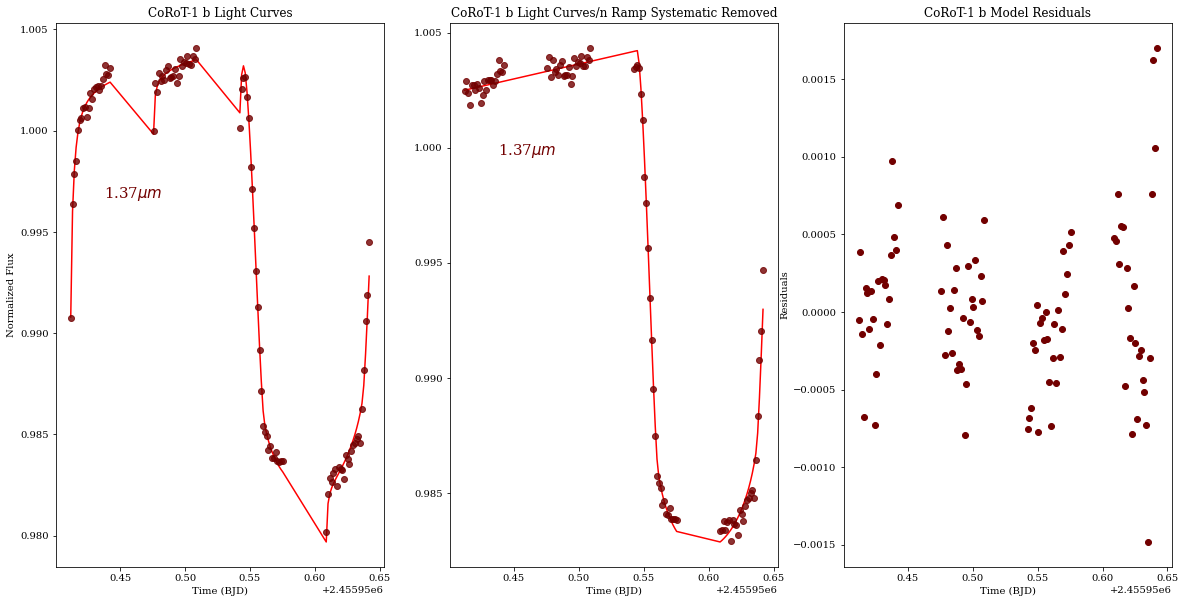

In [18]:
#Define the global parameters im, exptime for visit 1 from Previously read in saved results
info_v1 = corot1_visit1_results 
exptime = info_v1['Exp Time'][0]
im = median_image_v1

v1_wavebin_channels = optimize_batman_model_RECTE(spec_v1,transit_model_RECTE,nbins=1,showPlot=True)